In [1]:
%cd ..

/home/ec2-user/uclresearchanalysis


In [2]:
%matplotlib inline
import builtins
builtins.uclresearch_topic = 'GIVENCHY' #0 -- Finished
# builtins.uclresearch_topic = 'HAWKING' #0 -- Finished
# builtins.uclresearch_topic = 'NYC' # 88001
# builtins.uclresearch_topic = 'FLORIDA' # 448387
from configuration import config
from configuration.config import load_ml_data
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

import pickle
import shap

import multiprocessing
cpu_count = multiprocessing.cpu_count()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

('Reading config file from location: '
 '/home/ec2-user/uclresearchanalysis/configuration/env.properties')
{'calculate': {'analysis': True,
               'network': True,
               'uniquetweets': True,
               'uniqueusers': True},
 'data': {'dates': ['2018-03-11', '2018-03-12', '2018-03-13'],
          'eventname': "Givenchy's Death",
          'phrases': ['givenchy%20death', 'givenchy%20passed%20away'],
          'starttime': 'Mar 12 08:20:00 -0500 2018'},
 'path': {'crawl': {'followers': '/home/ec2-user/uclresearchanalysis/followers',
                    'friends': '/home/ec2-user/uclresearchanalysis/friends'},
          'cwd': '/home/ec2-user/uclresearchanalysis/data/givenchy',
          'ml': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle',
          'networkx': {'all': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_all.dat',
                       'friends': '/home/ec2-user/uclresearchanalysis/data/givenchy/pickle/networkx_friends.dat',


In [3]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
# Parameters
interval = 30

# 1. Prepare
def prepare_data(interval):
    df = load_ml_data(interval)
    df = df.reset_index(drop=True)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y


Loading data file from path /home/ec2-user/uclresearchanalysis/data/givenchy/pickle/30_data.dat
'Loaded 55559 entires'
[Original] data counts, with uninfected (0): 45777, infected (1): 9782


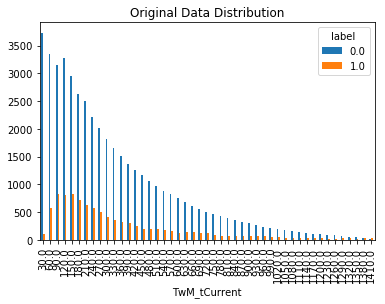

In [5]:
# 1. Prepare
df, X, y = prepare_data(interval)

In [6]:
feature_columns = X.columns
print('There are {} Features'.format(len(feature_columns)))

There are 88 Features


In [7]:
def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

In [8]:
def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

In [9]:
def train(df, X, y, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = xgb.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = xgb.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
#         evallist = []
        
        bst = xgb.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = xgb.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst


In [10]:
#xgboost
param = {
    'max_depth':3,
    # Step size shrinkage used in update to prevents overfitting. 
    # After each boosting step, we can directly get the weights of new features, 
    # and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': 0.1,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
    'gamma':10,
    # Minimum sum of instance weight (hessian) needed in a child. 
    # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    # then the building process will give up further partitioning.
    # The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':10,
    'silent': 1, # 0 means printing running messages, 1 means silent mode
    'objective': 'binary:logistic',
    'subsample': 0.9
}
param['nthread'] = cpu_count
param['eval_metric'] = ['auc']
num_boost_round = 1000
rebalance_method = 'up'

Start cross validation
===Processing fold 0===
1.0    22888
0.0    22888
Name: label, dtype: int64
[0]	train-auc:0.609509	eval-auc:0.596939
[1]	train-auc:0.62799	eval-auc:0.612529
[2]	train-auc:0.631334	eval-auc:0.614757
[3]	train-auc:0.633766	eval-auc:0.615939
[4]	train-auc:0.634903	eval-auc:0.617347
[5]	train-auc:0.638801	eval-auc:0.621328
[6]	train-auc:0.643184	eval-auc:0.62189
[7]	train-auc:0.647137	eval-auc:0.623697
[8]	train-auc:0.64696	eval-auc:0.624612
[9]	train-auc:0.648422	eval-auc:0.626923
[10]	train-auc:0.651821	eval-auc:0.629349
[11]	train-auc:0.652068	eval-auc:0.629726
[12]	train-auc:0.653669	eval-auc:0.630469
[13]	train-auc:0.654088	eval-auc:0.631524
[14]	train-auc:0.655741	eval-auc:0.631728
[15]	train-auc:0.658152	eval-auc:0.633772
[16]	train-auc:0.658945	eval-auc:0.634033
[17]	train-auc:0.660011	eval-auc:0.634537
[18]	train-auc:0.661085	eval-auc:0.635701
[19]	train-auc:0.661834	eval-auc:0.636306
[20]	train-auc:0.663151	eval-auc:0.636707
[21]	train-auc:0.665269	eval-auc

[192]	train-auc:0.767082	eval-auc:0.668734
[193]	train-auc:0.767287	eval-auc:0.668925
[194]	train-auc:0.767775	eval-auc:0.669034
[195]	train-auc:0.768546	eval-auc:0.669405
[196]	train-auc:0.768801	eval-auc:0.669397
[197]	train-auc:0.769273	eval-auc:0.669402
[198]	train-auc:0.769635	eval-auc:0.669706
[199]	train-auc:0.76987	eval-auc:0.669791
[200]	train-auc:0.770078	eval-auc:0.669799
[201]	train-auc:0.770204	eval-auc:0.669746
[202]	train-auc:0.77043	eval-auc:0.669921
[203]	train-auc:0.770665	eval-auc:0.669898
[204]	train-auc:0.770769	eval-auc:0.669899
[205]	train-auc:0.771383	eval-auc:0.669908
[206]	train-auc:0.771773	eval-auc:0.669885
[207]	train-auc:0.771897	eval-auc:0.669946
[208]	train-auc:0.772246	eval-auc:0.669884
[209]	train-auc:0.772355	eval-auc:0.669923
[210]	train-auc:0.772561	eval-auc:0.670153
[211]	train-auc:0.773445	eval-auc:0.670446
[212]	train-auc:0.774235	eval-auc:0.670644
[213]	train-auc:0.774746	eval-auc:0.670884
[214]	train-auc:0.774934	eval-auc:0.67106
[215]	train-au

[384]	train-auc:0.820413	eval-auc:0.682568
[385]	train-auc:0.820981	eval-auc:0.682793
[386]	train-auc:0.821126	eval-auc:0.682919
[387]	train-auc:0.821485	eval-auc:0.682967
[388]	train-auc:0.821707	eval-auc:0.683089
[389]	train-auc:0.822213	eval-auc:0.683274
[390]	train-auc:0.822535	eval-auc:0.683416
[391]	train-auc:0.822786	eval-auc:0.683441
[392]	train-auc:0.822876	eval-auc:0.683275
[393]	train-auc:0.823179	eval-auc:0.683476
[394]	train-auc:0.823237	eval-auc:0.683431
[395]	train-auc:0.823237	eval-auc:0.683431
[396]	train-auc:0.823319	eval-auc:0.683553
[397]	train-auc:0.82343	eval-auc:0.683451
[398]	train-auc:0.823782	eval-auc:0.683652
[399]	train-auc:0.824087	eval-auc:0.683705
[400]	train-auc:0.824224	eval-auc:0.68358
[401]	train-auc:0.824224	eval-auc:0.68358
[402]	train-auc:0.824224	eval-auc:0.68358
[403]	train-auc:0.824758	eval-auc:0.683796
[404]	train-auc:0.824906	eval-auc:0.683839
[405]	train-auc:0.82524	eval-auc:0.683856
[406]	train-auc:0.825461	eval-auc:0.683947
[407]	train-auc:

[576]	train-auc:0.854636	eval-auc:0.690159
[577]	train-auc:0.85488	eval-auc:0.690187
[578]	train-auc:0.855001	eval-auc:0.690279
[579]	train-auc:0.855019	eval-auc:0.690267
[580]	train-auc:0.855019	eval-auc:0.690267
[581]	train-auc:0.855113	eval-auc:0.690365
[582]	train-auc:0.855113	eval-auc:0.690365
[583]	train-auc:0.855111	eval-auc:0.690364
[584]	train-auc:0.855222	eval-auc:0.69045
[585]	train-auc:0.855222	eval-auc:0.69045
[586]	train-auc:0.855437	eval-auc:0.690569
[587]	train-auc:0.855482	eval-auc:0.690552
[588]	train-auc:0.855482	eval-auc:0.690552
[589]	train-auc:0.855757	eval-auc:0.690589
[590]	train-auc:0.855914	eval-auc:0.690648
[591]	train-auc:0.855914	eval-auc:0.690648
[592]	train-auc:0.855914	eval-auc:0.690648
[593]	train-auc:0.855937	eval-auc:0.690578
[594]	train-auc:0.85612	eval-auc:0.690621
[595]	train-auc:0.856186	eval-auc:0.690591
[596]	train-auc:0.856264	eval-auc:0.690685
[597]	train-auc:0.856288	eval-auc:0.690698
[598]	train-auc:0.856284	eval-auc:0.690648
[599]	train-auc

[768]	train-auc:0.87074	eval-auc:0.694734
[769]	train-auc:0.870965	eval-auc:0.694914
[770]	train-auc:0.871196	eval-auc:0.694882
[771]	train-auc:0.871196	eval-auc:0.694882
[772]	train-auc:0.871318	eval-auc:0.694899
[773]	train-auc:0.871435	eval-auc:0.694956
[774]	train-auc:0.871435	eval-auc:0.694956
[775]	train-auc:0.871512	eval-auc:0.695044
[776]	train-auc:0.871569	eval-auc:0.695162
[777]	train-auc:0.871803	eval-auc:0.695366
[778]	train-auc:0.871803	eval-auc:0.695366
[779]	train-auc:0.87194	eval-auc:0.695408
[780]	train-auc:0.872138	eval-auc:0.695406
[781]	train-auc:0.872209	eval-auc:0.695417
[782]	train-auc:0.872418	eval-auc:0.69554
[783]	train-auc:0.872421	eval-auc:0.695596
[784]	train-auc:0.872483	eval-auc:0.695653
[785]	train-auc:0.872483	eval-auc:0.695653
[786]	train-auc:0.872597	eval-auc:0.695656
[787]	train-auc:0.872597	eval-auc:0.695656
[788]	train-auc:0.872623	eval-auc:0.695668
[789]	train-auc:0.872851	eval-auc:0.695727
[790]	train-auc:0.872851	eval-auc:0.695727
[791]	train-au

[960]	train-auc:0.884797	eval-auc:0.69928
[961]	train-auc:0.885027	eval-auc:0.699323
[962]	train-auc:0.885125	eval-auc:0.699334
[963]	train-auc:0.885125	eval-auc:0.699334
[964]	train-auc:0.885204	eval-auc:0.69918
[965]	train-auc:0.88528	eval-auc:0.699077
[966]	train-auc:0.885329	eval-auc:0.699083
[967]	train-auc:0.885329	eval-auc:0.699083
[968]	train-auc:0.885329	eval-auc:0.699083
[969]	train-auc:0.885493	eval-auc:0.69916
[970]	train-auc:0.885767	eval-auc:0.699381
[971]	train-auc:0.885767	eval-auc:0.699381
[972]	train-auc:0.886081	eval-auc:0.699423
[973]	train-auc:0.886114	eval-auc:0.699521
[974]	train-auc:0.886114	eval-auc:0.699521
[975]	train-auc:0.88621	eval-auc:0.699674
[976]	train-auc:0.88621	eval-auc:0.699674
[977]	train-auc:0.886415	eval-auc:0.699697
[978]	train-auc:0.886451	eval-auc:0.699695
[979]	train-auc:0.886451	eval-auc:0.699695
[980]	train-auc:0.886451	eval-auc:0.699695
[981]	train-auc:0.886569	eval-auc:0.699751
[982]	train-auc:0.886569	eval-auc:0.699751
[983]	train-auc:0

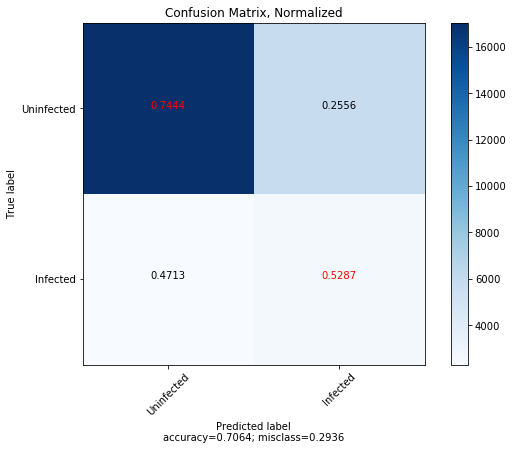

===Processing fold 1===
1.0    22889
0.0    22889
Name: label, dtype: int64
[0]	train-auc:0.606381	eval-auc:0.6066
[1]	train-auc:0.621852	eval-auc:0.620953
[2]	train-auc:0.623015	eval-auc:0.622112
[3]	train-auc:0.628032	eval-auc:0.628176
[4]	train-auc:0.631541	eval-auc:0.629611
[5]	train-auc:0.635213	eval-auc:0.633459
[6]	train-auc:0.636995	eval-auc:0.633159
[7]	train-auc:0.637801	eval-auc:0.634208
[8]	train-auc:0.637944	eval-auc:0.634881
[9]	train-auc:0.639228	eval-auc:0.634618
[10]	train-auc:0.641725	eval-auc:0.635245
[11]	train-auc:0.645948	eval-auc:0.638381
[12]	train-auc:0.646537	eval-auc:0.638854
[13]	train-auc:0.648324	eval-auc:0.639483
[14]	train-auc:0.649636	eval-auc:0.639326
[15]	train-auc:0.651608	eval-auc:0.640949
[16]	train-auc:0.652414	eval-auc:0.640838
[17]	train-auc:0.654208	eval-auc:0.641829
[18]	train-auc:0.655499	eval-auc:0.643196
[19]	train-auc:0.655597	eval-auc:0.643434
[20]	train-auc:0.656301	eval-auc:0.644115
[21]	train-auc:0.657329	eval-auc:0.644802
[22]	train-a

[193]	train-auc:0.760531	eval-auc:0.668889
[194]	train-auc:0.760748	eval-auc:0.669078
[195]	train-auc:0.76098	eval-auc:0.668979
[196]	train-auc:0.761483	eval-auc:0.668922
[197]	train-auc:0.761759	eval-auc:0.669118
[198]	train-auc:0.762764	eval-auc:0.669242
[199]	train-auc:0.763101	eval-auc:0.669142
[200]	train-auc:0.763469	eval-auc:0.669498
[201]	train-auc:0.764281	eval-auc:0.66996
[202]	train-auc:0.764895	eval-auc:0.670104
[203]	train-auc:0.765044	eval-auc:0.670148
[204]	train-auc:0.765296	eval-auc:0.670296
[205]	train-auc:0.765977	eval-auc:0.670417
[206]	train-auc:0.766344	eval-auc:0.670556
[207]	train-auc:0.766574	eval-auc:0.67054
[208]	train-auc:0.766871	eval-auc:0.670661
[209]	train-auc:0.767249	eval-auc:0.67058
[210]	train-auc:0.767771	eval-auc:0.67061
[211]	train-auc:0.768164	eval-auc:0.670735
[212]	train-auc:0.768717	eval-auc:0.67071
[213]	train-auc:0.768858	eval-auc:0.670709
[214]	train-auc:0.769515	eval-auc:0.670846
[215]	train-auc:0.769722	eval-auc:0.670748
[216]	train-auc:0

[385]	train-auc:0.817449	eval-auc:0.681259
[386]	train-auc:0.81768	eval-auc:0.68137
[387]	train-auc:0.818213	eval-auc:0.681467
[388]	train-auc:0.818562	eval-auc:0.681632
[389]	train-auc:0.818645	eval-auc:0.681563
[390]	train-auc:0.818976	eval-auc:0.681771
[391]	train-auc:0.819573	eval-auc:0.681892
[392]	train-auc:0.819815	eval-auc:0.681847
[393]	train-auc:0.819817	eval-auc:0.681817
[394]	train-auc:0.820126	eval-auc:0.681939
[395]	train-auc:0.820121	eval-auc:0.682069
[396]	train-auc:0.820268	eval-auc:0.682081
[397]	train-auc:0.820658	eval-auc:0.682192
[398]	train-auc:0.820885	eval-auc:0.682315
[399]	train-auc:0.821004	eval-auc:0.68217
[400]	train-auc:0.821259	eval-auc:0.682056
[401]	train-auc:0.821329	eval-auc:0.682048
[402]	train-auc:0.821508	eval-auc:0.682068
[403]	train-auc:0.821698	eval-auc:0.682259
[404]	train-auc:0.822297	eval-auc:0.682333
[405]	train-auc:0.822538	eval-auc:0.682399
[406]	train-auc:0.823089	eval-auc:0.682423
[407]	train-auc:0.823089	eval-auc:0.682423
[408]	train-au

[577]	train-auc:0.852106	eval-auc:0.690726
[578]	train-auc:0.852117	eval-auc:0.690786
[579]	train-auc:0.852335	eval-auc:0.690875
[580]	train-auc:0.852585	eval-auc:0.691001
[581]	train-auc:0.85271	eval-auc:0.691048
[582]	train-auc:0.852808	eval-auc:0.691155
[583]	train-auc:0.852808	eval-auc:0.691155
[584]	train-auc:0.85303	eval-auc:0.691251
[585]	train-auc:0.853292	eval-auc:0.691379
[586]	train-auc:0.853456	eval-auc:0.691141
[587]	train-auc:0.853456	eval-auc:0.691138
[588]	train-auc:0.853844	eval-auc:0.691363
[589]	train-auc:0.853844	eval-auc:0.691363
[590]	train-auc:0.854062	eval-auc:0.691272
[591]	train-auc:0.85426	eval-auc:0.691317
[592]	train-auc:0.854331	eval-auc:0.691255
[593]	train-auc:0.854775	eval-auc:0.691323
[594]	train-auc:0.854948	eval-auc:0.69138
[595]	train-auc:0.855053	eval-auc:0.691419
[596]	train-auc:0.855164	eval-auc:0.691429
[597]	train-auc:0.855427	eval-auc:0.691598
[598]	train-auc:0.855711	eval-auc:0.691539
[599]	train-auc:0.855711	eval-auc:0.691539
[600]	train-auc

[769]	train-auc:0.876865	eval-auc:0.697533
[770]	train-auc:0.876865	eval-auc:0.697533
[771]	train-auc:0.876865	eval-auc:0.697533
[772]	train-auc:0.876998	eval-auc:0.697644
[773]	train-auc:0.877228	eval-auc:0.697676
[774]	train-auc:0.877389	eval-auc:0.697703
[775]	train-auc:0.877389	eval-auc:0.697703
[776]	train-auc:0.877467	eval-auc:0.697764
[777]	train-auc:0.877484	eval-auc:0.697861
[778]	train-auc:0.877506	eval-auc:0.697851
[779]	train-auc:0.877638	eval-auc:0.697752
[780]	train-auc:0.87772	eval-auc:0.697768
[781]	train-auc:0.877842	eval-auc:0.697805
[782]	train-auc:0.877844	eval-auc:0.697794
[783]	train-auc:0.877844	eval-auc:0.697794
[784]	train-auc:0.878017	eval-auc:0.697909
[785]	train-auc:0.878328	eval-auc:0.698144
[786]	train-auc:0.878649	eval-auc:0.698462
[787]	train-auc:0.878754	eval-auc:0.698474
[788]	train-auc:0.87884	eval-auc:0.698666
[789]	train-auc:0.879049	eval-auc:0.698789
[790]	train-auc:0.879207	eval-auc:0.698796
[791]	train-auc:0.879341	eval-auc:0.698893
[792]	train-a

[961]	train-auc:0.889249	eval-auc:0.700441
[962]	train-auc:0.889393	eval-auc:0.700567
[963]	train-auc:0.889437	eval-auc:0.700568
[964]	train-auc:0.88953	eval-auc:0.700632
[965]	train-auc:0.889655	eval-auc:0.700704
[966]	train-auc:0.889655	eval-auc:0.700704
[967]	train-auc:0.88968	eval-auc:0.700734
[968]	train-auc:0.88968	eval-auc:0.700734
[969]	train-auc:0.889796	eval-auc:0.700827
[970]	train-auc:0.889956	eval-auc:0.700884
[971]	train-auc:0.890041	eval-auc:0.700905
[972]	train-auc:0.890041	eval-auc:0.700905
[973]	train-auc:0.890041	eval-auc:0.700905
[974]	train-auc:0.890041	eval-auc:0.700905
[975]	train-auc:0.89006	eval-auc:0.700909
[976]	train-auc:0.890075	eval-auc:0.70088
[977]	train-auc:0.890075	eval-auc:0.70088
[978]	train-auc:0.890075	eval-auc:0.70088
[979]	train-auc:0.890075	eval-auc:0.70088
[980]	train-auc:0.890096	eval-auc:0.700952
[981]	train-auc:0.890237	eval-auc:0.701061
[982]	train-auc:0.890431	eval-auc:0.701151
[983]	train-auc:0.89042	eval-auc:0.701144
[984]	train-auc:0.89

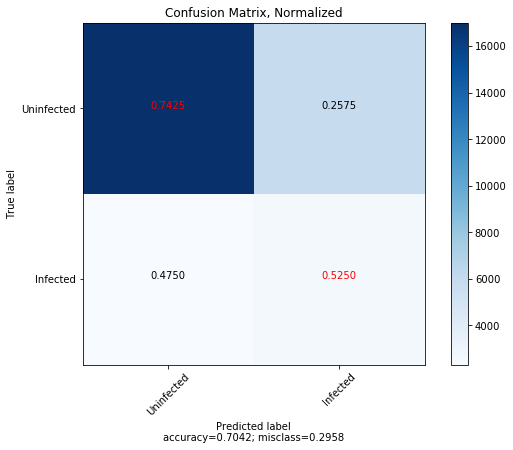

Finished cross validation
MSE: 0    0.193744
dtype: float64 
ACC: 0    0.705322
dtype: float64 
AUC: 0    0.700966
dtype: float64 
ACC for t at 210: 0    0.65398
dtype: float64 
Empty DataFrame
Columns: [average corr]
Index: []


In [11]:
xgb_model = train(df, X, y, param, 2, num_boost_round, rebalance_method)

In [12]:
columns = list(df.columns)
columns.remove('label')
if rebalance_method == 'up':
    df_rebalance = upsample(df)
if rebalance_method == 'down':
    df_rebalance = downsample(df)
X = df_rebalance[columns]
y = df_rebalance[['label']]

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model

model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

1.0    45777
0.0    45777
Name: label, dtype: int64


In [13]:
with open('xgb_model_{}.dat'.format(builtins.uclresearch_topic), 'wb') as file:
    pickle.dump(model, file)

In [14]:
subsample = list(range(1,len(shap_values),int(len(shap_values)/1000)))

In [15]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[subsample,:], X.iloc[subsample,:])

In [16]:
X.columns[0]

'UsM_deltaDays'

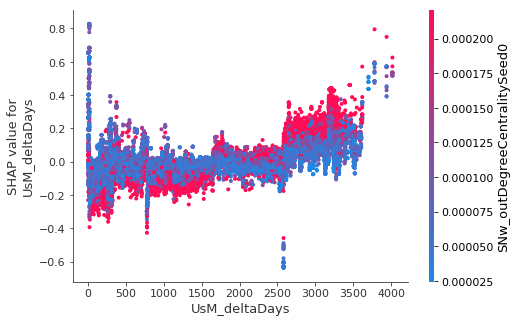

In [17]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(X.columns[0], shap_values, X)

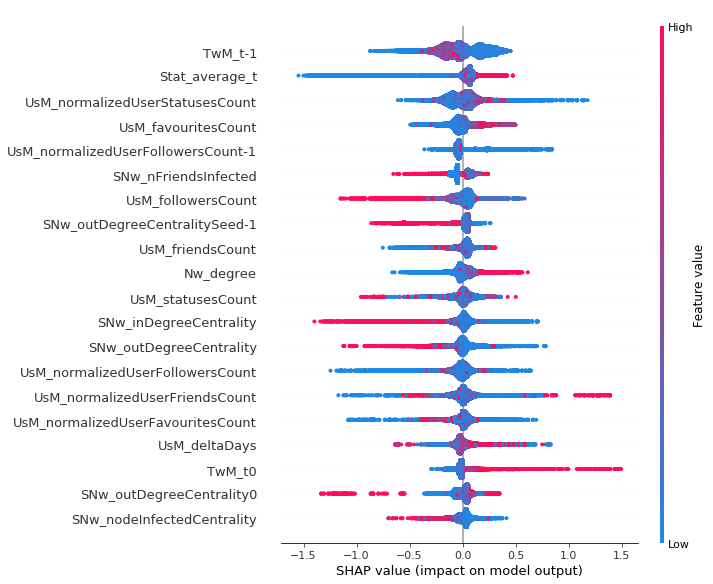

In [18]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

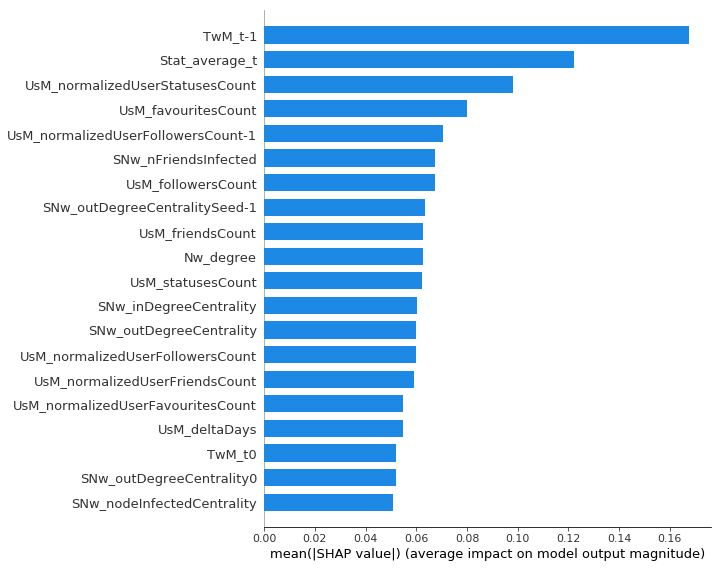

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

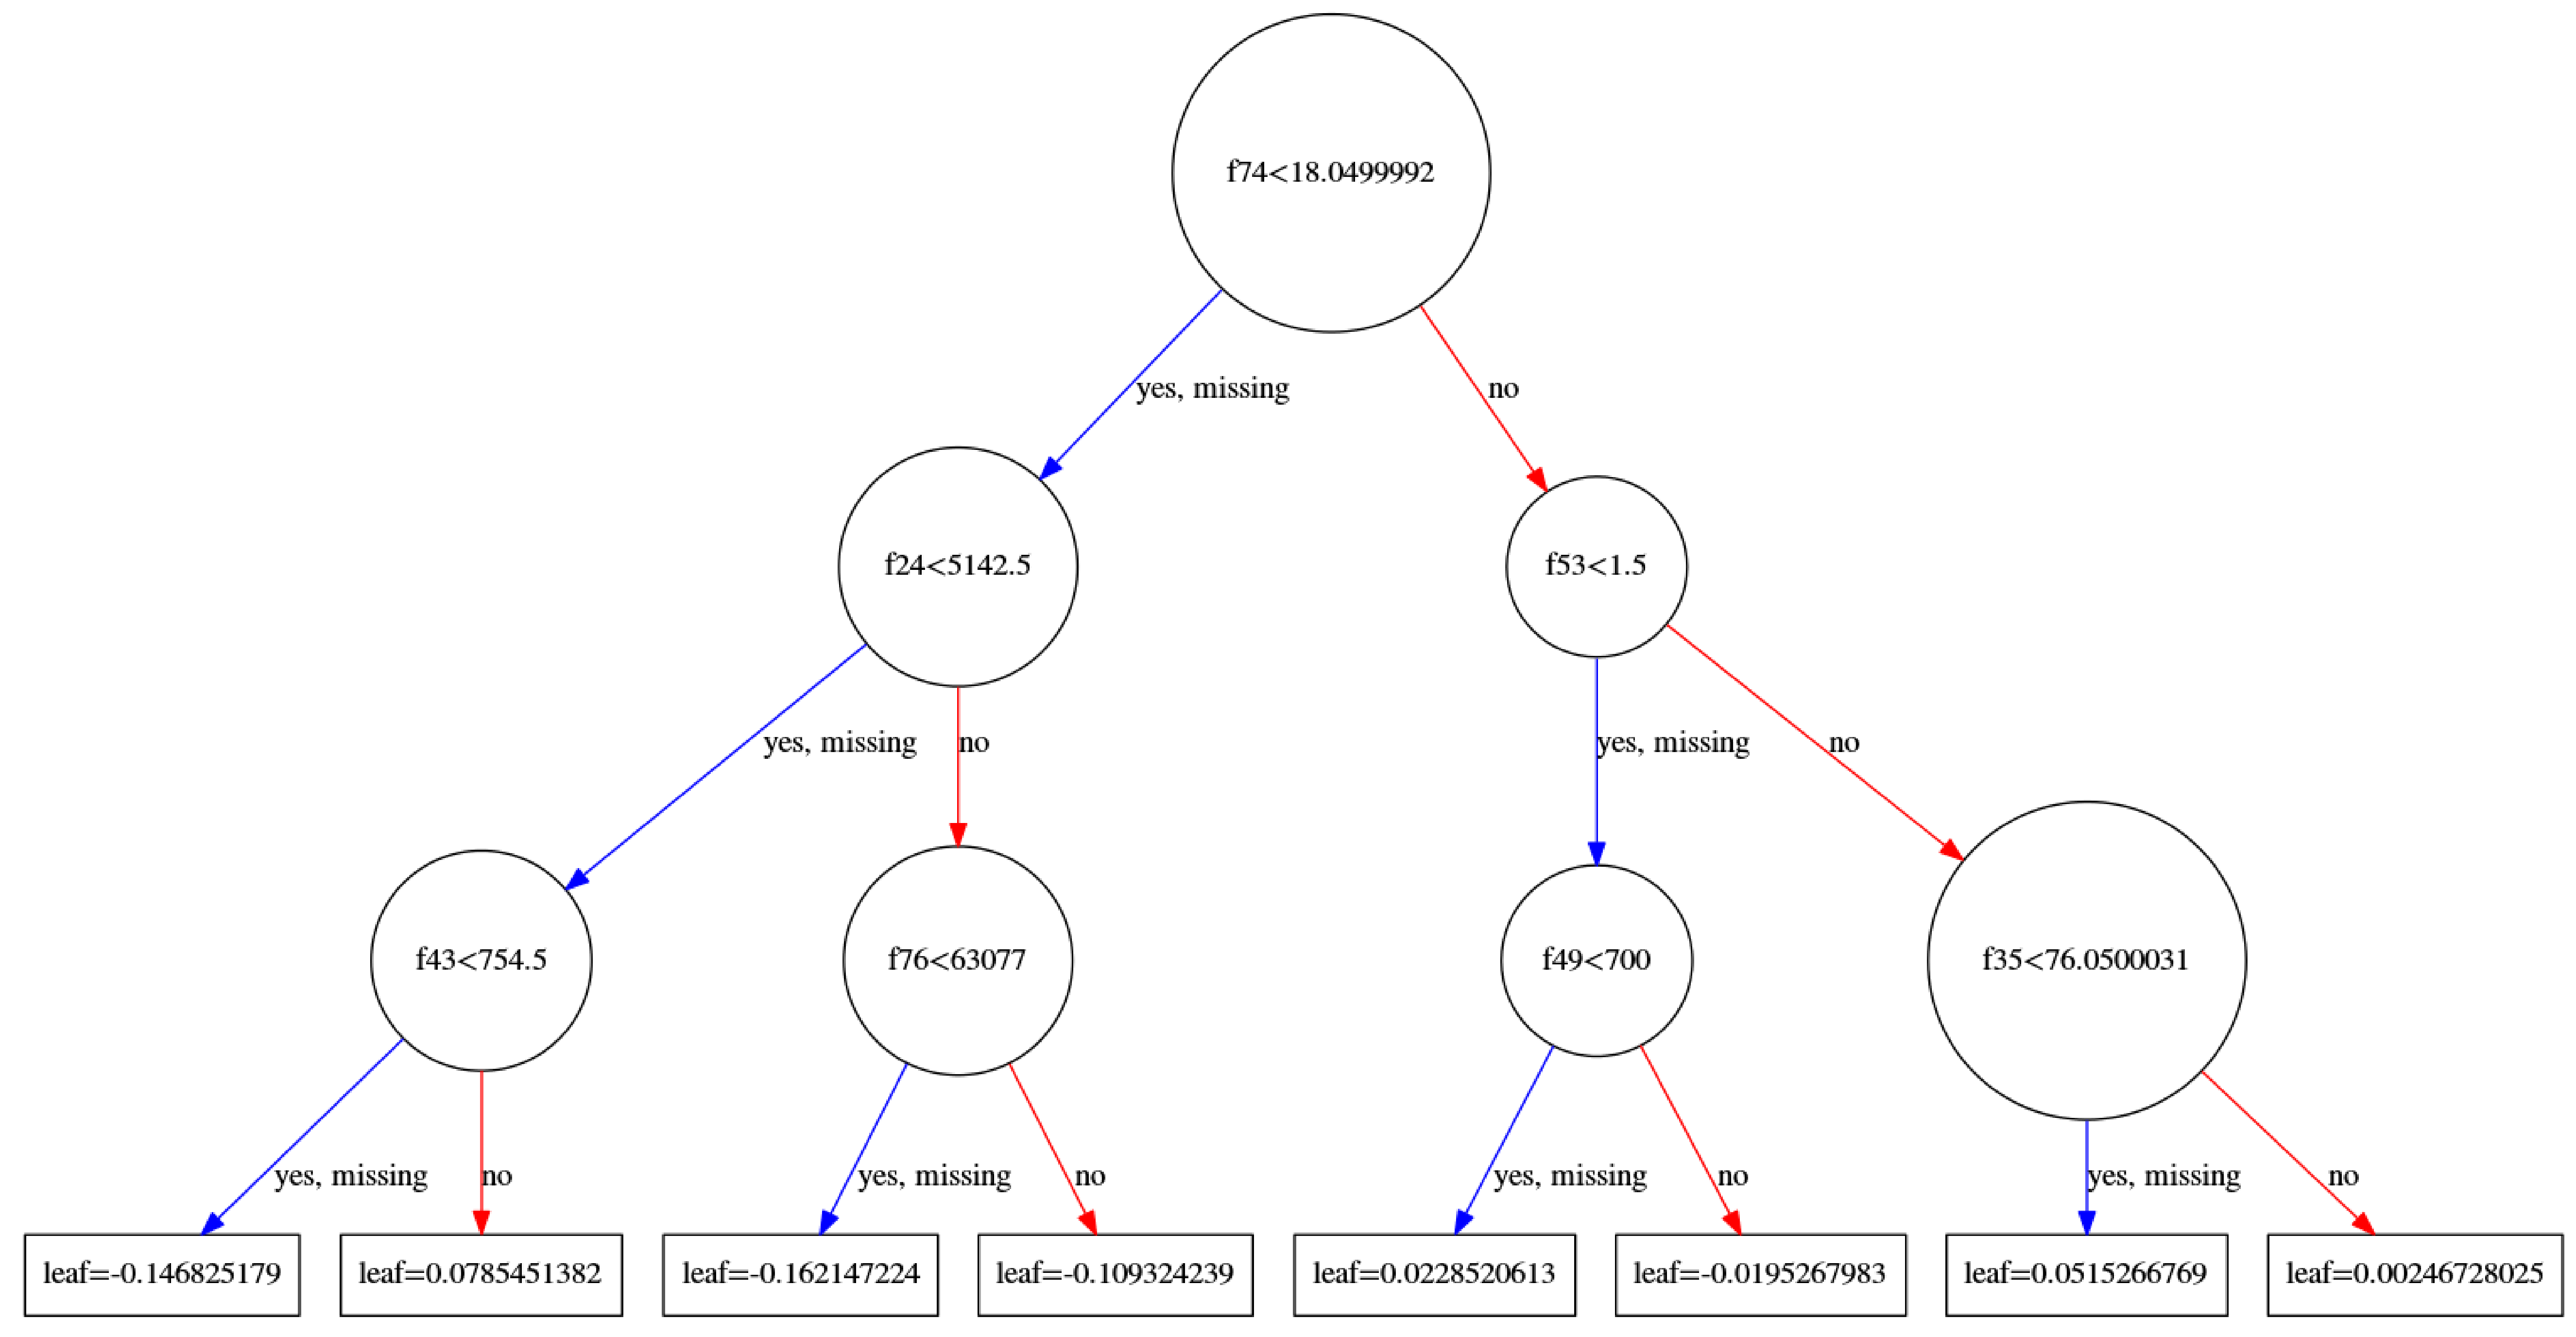

In [20]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_model, num_trees=1)

fig = plt.gcf()
fig.set_size_inches(100, 50)
plt.show()

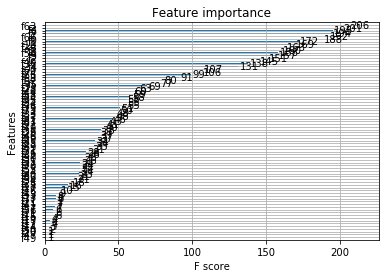

In [21]:
xgb.plot_importance(xgb_model)
fig = plt.gcf()
# fig.set_size_inches(50, 100)
plt.show()